In [1]:
# Import all necessary libraries. 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import math
from scipy.special import erfc

In [2]:
# By default, keras uses Glorot initialization with a Uniform distribution. You can switch to He initialization 
# by setting the kernel initializer. 

dense = tf.keras.layers.Dense(50, activation="relu", kernel_initializer="he_normal")

he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg", distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid", kernel_initializer=he_avg_init)

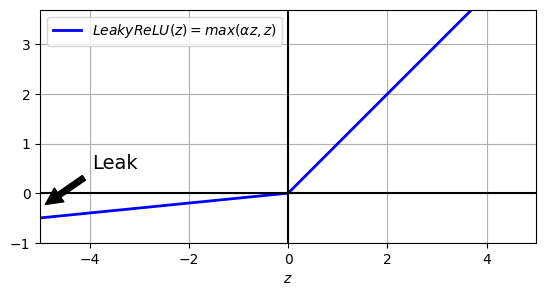

In [4]:
# We can also use better types of activation functions that may remedy the vanishing gradient problem
# and optimize the neural network models we build. Here are a few for demonstration. 

# Here is a leaky relu activation and how we can use it. 

def leaky_relu(z, alpha):
    return np.maximum(alpha*z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()
plt.show()

In [5]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)
dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")

c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [6]:
# There is also eLU and seLU. 

dense = tf.keras.layers.Dense(50, activation="elu",
                              kernel_initializer="he_normal")

In [7]:
dense = tf.keras.layers.Dense(50, activation="selu",
                              kernel_initializer="he_normal")

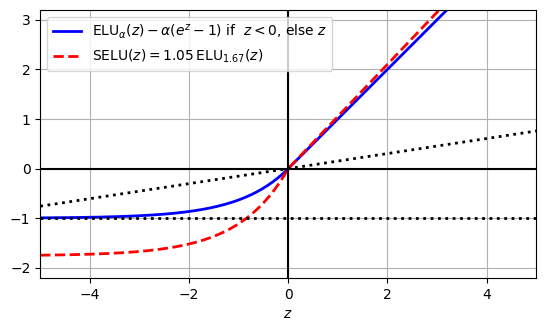

In [9]:
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 =  (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 /2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) - \alpha(e^z - 1)$ if  $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-0.758, 0.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()
plt.show()

In [10]:
# We now build a self-regularized neural network with SELU as the activation function on the Fashion MNIST
# data set. 

tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=['accuracy'])

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [3]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal",
               "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [4]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [20]:
# After importing the data and creating the training, validation, and testing sets, run and fit the model. 

fashion_mnist_model = model.fit(X_train_scaled, y_train, epochs=5,
                                validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.1009 - loss: 2.3056 - val_accuracy: 0.1006 - val_loss: 2.3042
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.1021 - loss: 2.3044 - val_accuracy: 0.1006 - val_loss: 2.3042
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - accuracy: 0.1021 - loss: 2.3044 - val_accuracy: 0.1006 - val_loss: 2.3042
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.1021 - loss: 2.3044 - val_accuracy: 0.1006 - val_loss: 2.3042
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.1021 - loss: 2.3044 - val_accuracy: 0.1006 - val_loss: 2.3042


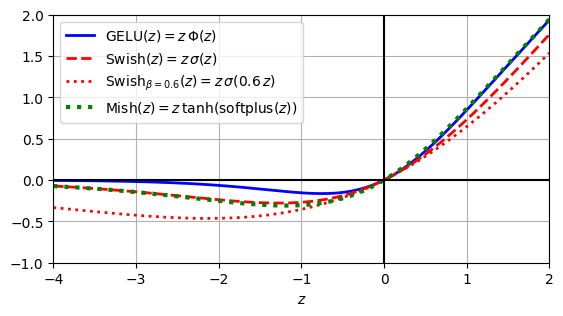

In [21]:
# There is also GELU, Swish, and Mish. 

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")
plt.show()

In [22]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [23]:
# We now look into Batch Normalization. 

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 784)            │         3,136 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271,346 (1.04 MB)

 Trainable params: 268,978 (1.03 MB)

 Non-trainable params: 2,368 (9.25 KB)

In [25]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('gamma', True),
 ('beta', True),
 ('moving_mean', False),
 ('moving_variance', False)]

In [26]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7603 - loss: 0.7117 - val_accuracy: 0.8530 - val_loss: 0.4015
Epoch 2/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8576 - loss: 0.4052 - val_accuracy: 0.8646 - val_loss: 0.3686


In [27]:
# Another technique to address the vanishing gradients problem is to perform gradient clipping. 
# Clip the gradients during backpropagation so that they never exceed some threshold.

optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

In [28]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

In [5]:
# We now look into reusing layers during training of our neural networks. 

pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id 
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)
model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics = ["accuracy"])

history = model_A.fit(X_train_A, y_train_A, epochs=20, validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A.keras")

c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5095 - loss: 1.4992 - val_accuracy: 0.7984 - val_loss: 0.6694
Epoch 2/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8086 - loss: 0.6245 - val_accuracy: 0.8393 - val_loss: 0.4984
Epoch 3/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8456 - loss: 0.4884 - val_accuracy: 0.8561 - val_loss: 0.4278
Epoch 4/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8614 - loss: 0.4243 - val_accuracy: 0.8681 - val_loss: 0.3877
Epoch 5/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8712 - loss: 0.3857 - val_accuracy: 0.8732 - val_loss: 0.3619
Epoch 6/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8779 - loss: 0.3595 - val_accuracy: 0.8782 - val_loss: 0.3436
Epoch 7/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8847 - loss: 0.3401 - val_accuracy: 0.8827 - val_loss: 0.3299
Epoch 8/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8893 - loss: 0.3251 - 

In [6]:
# We now train model B without reusing model A. 

tf.random.set_seed(42)
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20, validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.4408 - loss: 0.6925 - val_accuracy: 0.5094 - val_loss: 0.6483
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4794 - loss: 0.6595 - val_accuracy: 0.5668 - val_loss: 0.6232
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5702 - loss: 0.6299 - val_accuracy: 0.6686 - val_loss: 0.5993
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6546 - loss: 0.6020 - val_accuracy: 0.7507 - val_loss: 0.5767
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7747 - loss: 0.5762 - val_accuracy: 0.8081 - val_loss: 0.5557
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8508 - loss: 0.5527 - val_accuracy: 0.8447 - val_loss: 0.5358
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8844 - loss: 0.5310 - val_accuracy: 0.8635 - val_loss: 0.5180
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8883 - loss: 0.5114 - val_accuracy: 0.8793 - val_loss: 0.5017


[0.38582316040992737, 0.921500027179718]

In [7]:
# Now we reuse the pretrained model A. 

model_A = tf.keras.models.load_model("my_model_A.keras")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [8]:
# Note that model_B_on_A shares layers with model A now and will update both at once. We can stop this
# by making a clone of model A. 

tf.random.set_seed(42)
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16, validation_data=(X_valid_B, y_valid_B))

Epoch 1/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5955 - loss: 0.6034 - val_accuracy: 0.8150 - val_loss: 0.5338
Epoch 2/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7887 - loss: 0.5299 - val_accuracy: 0.8487 - val_loss: 0.5174
Epoch 3/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8163 - loss: 0.5119 - val_accuracy: 0.8536 - val_loss: 0.5100
Epoch 4/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8133 - loss: 0.5033 - val_accuracy: 0.8576 - val_loss: 0.5043
Epoch 5/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8251 - loss: 0.4969 - val_accuracy: 0.8635 - val_loss: 0.4992
Epoch 6/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8379 - loss: 0.4911 - val_accuracy: 0.8665 - val_loss: 0.4942
Epoch 7/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8405 - loss: 0.4857 - val_accuracy: 0.8704 - val_loss: 0.4894
Epoch 8/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8509 - loss: 0.4804 - val_accuracy: 0.8744 - val_loss: 0.4847
E

In [9]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.8878 - loss: 0.4429


[0.446048378944397, 0.8824999928474426]

In [10]:
# We implement faster optimizers here other than the traditional SGD and Adam optimizers. 

def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

In [11]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
history_sgd = build_and_train_model(optimizer)

c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6741 - loss: 0.9840 - val_accuracy: 0.8100 - val_loss: 0.5158
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8303 - loss: 0.4877 - val_accuracy: 0.8254 - val_loss: 0.4660
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8482 - loss: 0.4357 - val_accuracy: 0.8396 - val_loss: 0.4258
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8590 - loss: 0.4046 - val_accuracy: 0.8498 - val_loss: 0.4013
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8657 - loss: 0.3826 - val_accuracy: 0.8570 - val_loss: 0.3888
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8717 - loss: 0.3653 - val_accuracy: 0.8596 - val_loss: 0.3790
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8765 - loss: 0.3507 - val_accuracy: 0.8618 - val_loss: 0.3730
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8808 - loss: 0.3383 - 

In [13]:
# We now implement Nesterov Accelerated Descent. 

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
history_nesterov = build_and_train_model(optimizer)

Epoch 1/10


c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6717 - loss: 0.9748 - val_accuracy: 0.8276 - val_loss: 0.4999
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8310 - loss: 0.4795 - val_accuracy: 0.8368 - val_loss: 0.4525
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8508 - loss: 0.4262 - val_accuracy: 0.8432 - val_loss: 0.4280
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8603 - loss: 0.3955 - val_accuracy: 0.8496 - val_loss: 0.4085
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8675 - loss: 0.3738 - val_accuracy: 0.8510 - val_loss: 0.3967
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8735 - loss: 0.3572 - val_accuracy: 0.8532 - val_loss: 0.3880
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8789 - loss: 0.3436 - val_accuracy: 0.8562 - val_loss: 0.3804
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8819 - loss: 0.3320 - val_accurac

In [16]:
# We implement AdaGrad as an optimizer.

optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)
history_adagrad = build_and_train_model(optimizer)

Epoch 1/10


c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5545 - loss: 1.3736 - val_accuracy: 0.7708 - val_loss: 0.6971
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7782 - loss: 0.6807 - val_accuracy: 0.8050 - val_loss: 0.5950
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8046 - loss: 0.5945 - val_accuracy: 0.8182 - val_loss: 0.5484
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8171 - loss: 0.5515 - val_accuracy: 0.8266 - val_loss: 0.5204
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8251 - loss: 0.5245 - val_accuracy: 0.8334 - val_loss: 0.5012
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8312 - loss: 0.5056 - val_accuracy: 0.8362 - val_loss: 0.4869
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8354 - loss: 0.4913 - val_accuracy: 0.8372 - val_loss: 0.4757
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8389 - loss: 0.4799 - val_accurac

In [17]:
# We now implement RMSProp as an optimizer. 

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
history_rmsprop = build_and_train_model(optimizer)

c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7649 - loss: 0.6563 - val_accuracy: 0.8262 - val_loss: 0.4585
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8561 - loss: 0.4035 - val_accuracy: 0.8424 - val_loss: 0.4138
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8690 - loss: 0.3706 - val_accuracy: 0.8546 - val_loss: 0.4147
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8749 - loss: 0.3569 - val_accuracy: 0.8496 - val_loss: 0.4450
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8781 - loss: 0.3513 - val_accuracy: 0.8458 - val_loss: 0.4874
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8820 - loss: 0.3427 - val_accuracy: 0.8372 - val_loss: 0.5643
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8824 - loss: 0.3412 - val_accuracy: 0.8580 - val_loss: 0.4748
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8849 - loss: 0.3361 

In [18]:
# We now implement Adam optimization. 

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
history_adam = build_and_train_model(optimizer)

Epoch 1/10


c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7706 - loss: 0.6452 - val_accuracy: 0.8356 - val_loss: 0.4261
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8578 - loss: 0.3881 - val_accuracy: 0.8446 - val_loss: 0.4034
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8731 - loss: 0.3450 - val_accuracy: 0.8502 - val_loss: 0.3889
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8815 - loss: 0.3202 - val_accuracy: 0.8554 - val_loss: 0.3837
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8891 - loss: 0.2991 - val_accuracy: 0.8558 - val_loss: 0.3901
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8921 - loss: 0.2863 - val_accuracy: 0.8660 - val_loss: 0.3703
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8991 - loss: 0.2727 - val_accuracy: 0.8722 - val_loss: 0.3682
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9017 - loss: 0.2627 - val_accurac

In [19]:
# We implement AdaMax as an optimizer. 

optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
history_adamax = build_and_train_model(optimizer)

c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7558 - loss: 0.7195 - val_accuracy: 0.8314 - val_loss: 0.4426
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8547 - loss: 0.4120 - val_accuracy: 0.8482 - val_loss: 0.3985
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8689 - loss: 0.3673 - val_accuracy: 0.8592 - val_loss: 0.3663
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8784 - loss: 0.3393 - val_accuracy: 0.8690 - val_loss: 0.3507
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8858 - loss: 0.3194 - val_accuracy: 0.8706 - val_loss: 0.3439
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8905 - loss: 0.3039 - val_accuracy: 0.8746 - val_loss: 0.3352
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8952 - loss: 0.2908 - val_accuracy: 0.8766 - val_loss: 0.3315
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9007 - loss: 0.2789 - 

In [21]:
# We now implement Nadam as an optimizer. 

optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
history_nadam = build_and_train_model(optimizer)

Epoch 1/10


c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7823 - loss: 0.6288 - val_accuracy: 0.8268 - val_loss: 0.4543
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8634 - loss: 0.3788 - val_accuracy: 0.8508 - val_loss: 0.3974
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8767 - loss: 0.3380 - val_accuracy: 0.8600 - val_loss: 0.3755
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8840 - loss: 0.3111 - val_accuracy: 0.8604 - val_loss: 0.3873
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8925 - loss: 0.2911 - val_accuracy: 0.8654 - val_loss: 0.3622
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8971 - loss: 0.2725 - val_accuracy: 0.8696 - val_loss: 0.3684
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9001 - loss: 0.2632 - val_accuracy: 0.8656 - val_loss: 0.3880
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9055 - loss: 0.2491 - val_accurac

In [22]:
# We now implement AdamW as an optimizer.

optimizer = tf.keras.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001, beta_1=0.9, beta_2=0.999)
history_adamw = build_and_train_model(optimizer)

Epoch 1/10


c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7707 - loss: 0.6470 - val_accuracy: 0.8312 - val_loss: 0.4397
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8573 - loss: 0.3913 - val_accuracy: 0.8310 - val_loss: 0.4399
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8718 - loss: 0.3480 - val_accuracy: 0.8494 - val_loss: 0.3996
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8806 - loss: 0.3202 - val_accuracy: 0.8452 - val_loss: 0.4195
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8875 - loss: 0.2991 - val_accuracy: 0.8694 - val_loss: 0.3501
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8956 - loss: 0.2817 - val_accuracy: 0.8744 - val_loss: 0.3525
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9015 - loss: 0.2661 - val_accuracy: 0.8768 - val_loss: 0.3417
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9040 - loss: 0.2552 - val_accurac

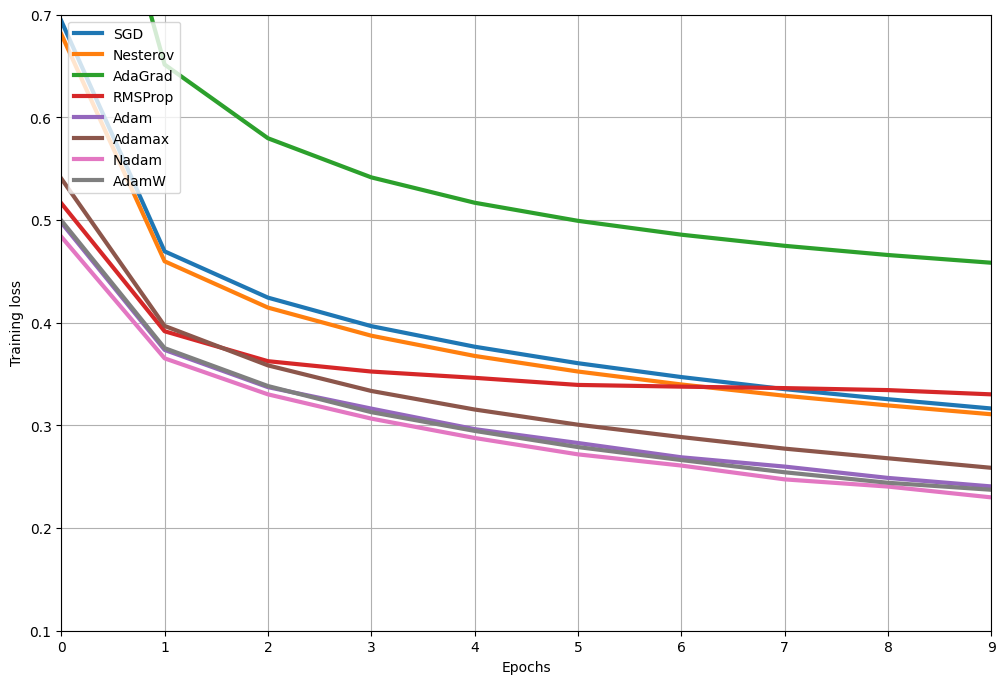

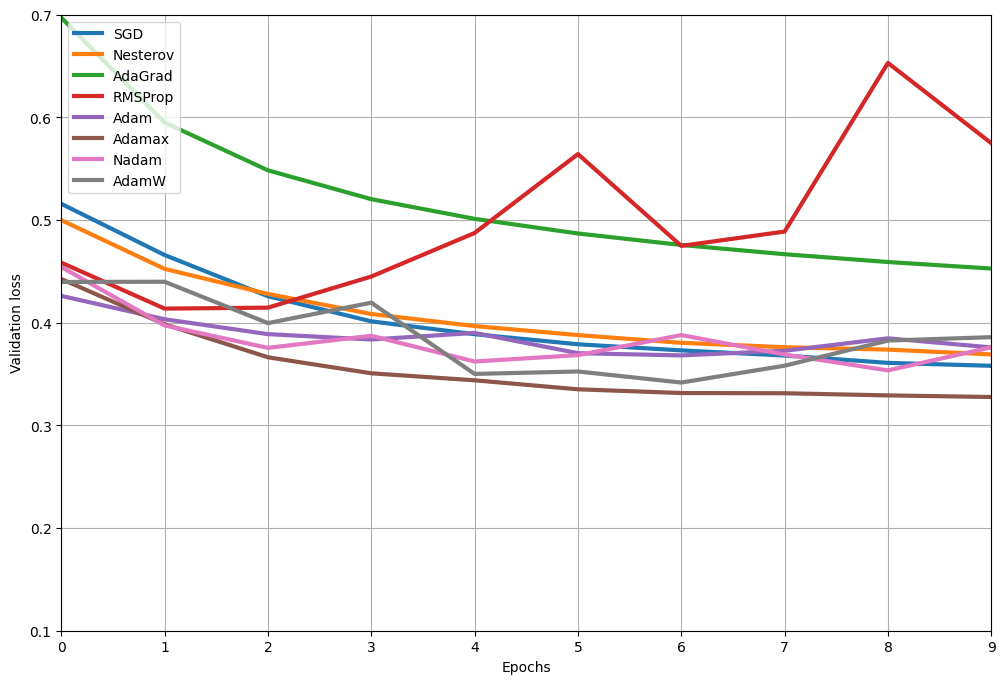

In [23]:
# Plot and visualize the different optimizers we have implemented by training and validation losses. 

for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

In [26]:
# We now implement learning rate scheduling, in particular we use power scheduling here.

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=10_000,
    decay_rate=1.0,
    staircase=False
)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
history_power_scheduling = build_and_train_model(optimizer)

c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6720 - loss: 0.9758 - val_accuracy: 0.8208 - val_loss: 0.5020
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8271 - loss: 0.4966 - val_accuracy: 0.8402 - val_loss: 0.4545
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8438 - loss: 0.4447 - val_accuracy: 0.8452 - val_loss: 0.4322
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8545 - loss: 0.4156 - val_accuracy: 0.8536 - val_loss: 0.4184
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8616 - loss: 0.3957 - val_accuracy: 0.8572 - val_loss: 0.4032
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8666 - loss: 0.3807 - val_accuracy: 0.8626 - val_loss: 0.3936
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8704 - loss: 0.3687 - val_accuracy: 0.8632 - val_loss: 0.3855
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8732 - loss: 0.3587 - 

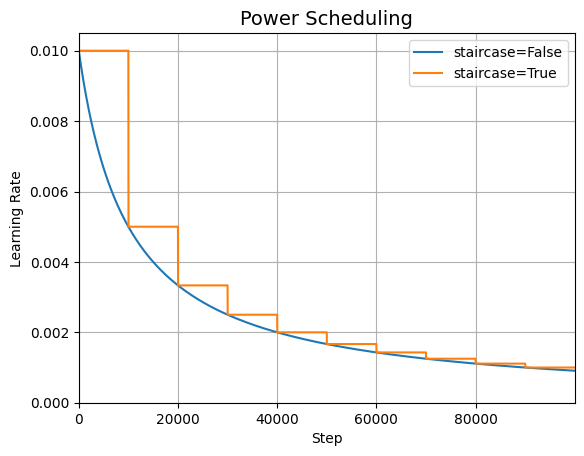

In [27]:
# Plot the power scheduling with staircase. 

initial_learning_rate = 0.01
decay_rate = 1.0
decay_steps = 10_000

steps = np.arange(100_000)
lrs = initial_learning_rate / (1 + decay_rate * steps / decay_steps)
lrs2 = initial_learning_rate / (1 + decay_rate * np.floor(steps / decay_steps))

plt.plot(steps, lrs,  "-", label="staircase=False")
plt.plot(steps, lrs2,  "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# We now implement exponential scheduling. 

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps = 20_000,
    decay_rate=0.1,
    staircase=False
)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
history_exponential_scheduling = build_and_train_model(optimizer)

Epoch 1/10


c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6677 - loss: 0.9773 - val_accuracy: 0.8194 - val_loss: 0.5036
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8272 - loss: 0.4960 - val_accuracy: 0.8338 - val_loss: 0.4609
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8452 - loss: 0.4446 - val_accuracy: 0.8438 - val_loss: 0.4365
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8550 - loss: 0.4169 - val_accuracy: 0.8492 - val_loss: 0.4196
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8615 - loss: 0.3981 - val_accuracy: 0.8560 - val_loss: 0.4059
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8657 - loss: 0.3845 - val_accuracy: 0.8586 - val_loss: 0.3947
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8689 - loss: 0.3744 - val_accuracy: 0.8636 - val_loss: 0.3864
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8721 - loss: 0.3665 - val_accurac

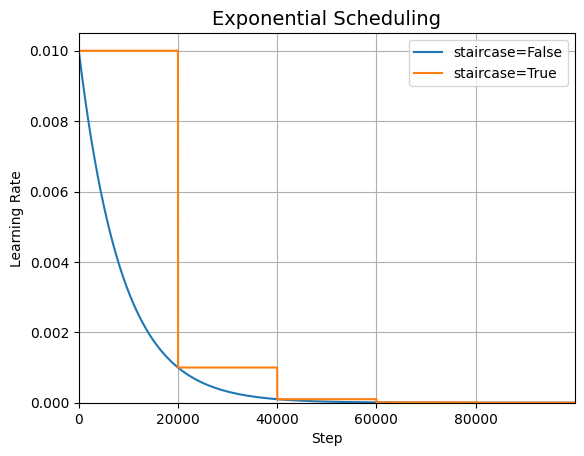

In [29]:
# Plot the exponential scheduling with the staircase superimposed. 

initial_learning_rate = 0.01
decay_rate = 0.1
decay_steps = 20_000

steps = np.arange(100_000)
lrs = initial_learning_rate * decay_rate ** (steps / decay_steps)
lrs2 = initial_learning_rate * decay_rate ** np.floor(steps / decay_steps)

plt.plot(steps, lrs,  "-", label="staircase=False")
plt.plot(steps, lrs2,  "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# Keras also provides a learning rate scheduler callback class that lets us define our own scheduling function.

def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch/20)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch/s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [32]:
tf.random.set_seed(42)
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer = optimizer, metrics=["accuracy"])
n_epochs = 20
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, epochs=n_epochs, validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6773 - loss: 0.9678 - val_accuracy: 0.8270 - val_loss: 0.4865 - learning_rate: 0.0100
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8276 - loss: 0.4939 - val_accuracy: 0.8412 - val_loss: 0.4400 - learning_rate: 0.0089
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8462 - loss: 0.4387 - val_accuracy: 0.8498 - val_loss: 0.4194 - learning_rate: 0.0079
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8560 - loss: 0.4084 - val_accuracy: 0.8554 - val_loss: 0.4043 - learning_rate: 0.0071
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8646 - loss: 0.3876 - val_accuracy: 0.8574 - val_loss: 0.3977 - learning_rate: 0.0063
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8699 - loss: 0.3725 - val_accuracy: 0.8616 - val_loss: 0.3887 - learning_rate: 0.0056
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8735 - l

In [34]:
# We can also write our own custom scheduling function, here we write a custom scheduling function that 
# updates the learning rate at each iteration rather than at each epoch. 

K = tf.keras.backend

class ExponentialDecay(tf.keras.callbacks.Callback):
    def __init__(self, n_steps=40_000):
        super().__init__()
        self.n_steps = n_steps

    def on_batch_begin(self, batch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy()
        new_learning_rate = lr * 0.1 ** (1/self.n_steps)
        self.model.optimizer.learning_rate = new_learning_rate

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = self.model.optimizer.learning_rate.numpy()

In [35]:
lr = 0.01
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [36]:
batch_size = 32
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
exp_decay = ExponentialDecay(n_steps)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data = (X_valid, y_valid),
                    callbacks=[exp_decay])

Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6743 - loss: 0.9865 - val_accuracy: 0.8238 - val_loss: 0.4945 - lr: 0.0089
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8276 - loss: 0.4924 - val_accuracy: 0.8344 - val_loss: 0.4553 - lr: 0.0079
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8468 - loss: 0.4376 - val_accuracy: 0.8432 - val_loss: 0.4360 - lr: 0.0071
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.8570 - loss: 0.4071 - val_accuracy: 0.8504 - val_loss: 0.4218 - lr: 0.0063
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8642 - loss: 0.3866 - val_accuracy: 0.8516 - val_loss: 0.4110 - lr: 0.0056
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8684 - loss: 0.3707 - val_accuracy: 0.8558 - val_loss: 0.4002 - lr: 0.0050
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8723 - loss: 0.3581 - val_accuracy: 0.8600 - val_loss: 0.3930 - lr: 0.0

In [37]:
# We now perform piecewise constant scheduling. 

lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[50_000, 80_000],
    values=[0.01, 0.005, 0.001]
)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
history_piecewise_scheduling = build_and_train_model(optimizer)

c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6517 - loss: 0.9980 - val_accuracy: 0.8258 - val_loss: 0.5028
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8223 - loss: 0.5048 - val_accuracy: 0.8386 - val_loss: 0.4476
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8422 - loss: 0.4443 - val_accuracy: 0.8448 - val_loss: 0.4228
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8546 - loss: 0.4100 - val_accuracy: 0.8478 - val_loss: 0.4132
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8620 - loss: 0.3861 - val_accuracy: 0.8530 - val_loss: 0.4023
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8688 - loss: 0.3679 - val_accuracy: 0.8500 - val_loss: 0.4013
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8734 - loss: 0.3537 - val_accuracy: 0.8518 - val_loss: 0.3960
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8781 - loss: 0.3411 - 

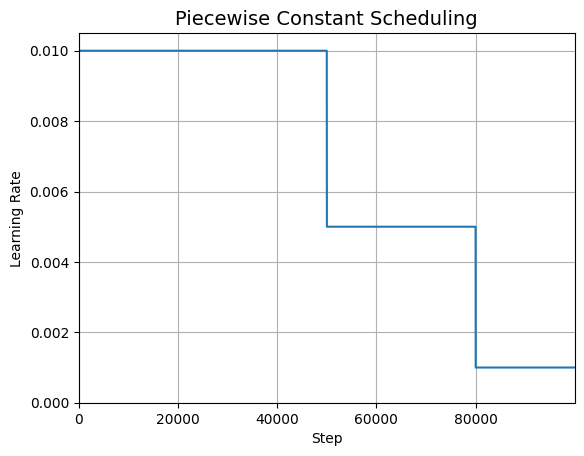

In [38]:
# Plot the  piecewise constant scheduling.

boundaries = [50_000, 80_000]
values = [0.01, 0.005, 0.001]

steps = np.arange(100_000)

lrs = np.full(len(steps), values[0])
for boundary, value in zip(boundaries, values[1:]):
    lrs[boundary:] = value

plt.plot(steps, lrs, "-")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [41]:
# Just like before, we can also implement piecewise constant scheduling manually with our 
# custom function. 

def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001
    
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[(boundaries > epoch).argmax() - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

n_epochs = 25

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = build_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.7536 - loss: 0.7101 - val_accuracy: 0.8260 - val_loss: 0.4966 - learning_rate: 0.0100
Epoch 2/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8385 - loss: 0.4559 - val_accuracy: 0.8272 - val_loss: 0.4697 - learning_rate: 0.0100
Epoch 3/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8473 - loss: 0.4308 - val_accuracy: 0.8304 - val_loss: 0.4492 - learning_rate: 0.0100
Epoch 4/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.8505 - loss: 0.4303 - val_accuracy: 0.8358 - val_loss: 0.4338 - learning_rate: 0.0100
Epoch 5/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8563 - loss: 0.4099 - val_accuracy: 0.8280 - val_loss: 0.4660 - learning_rate: 0.0100
Epoch 6/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8718 - loss: 0.3586 - val_accuracy: 0.8570 - val_loss: 0.4030 - learning_rate: 0.0050
Epoch 7/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.876

In [44]:
# We now implement performance scheduling. 

model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=lr_scheduler)

Epoch 1/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6787 - loss: 0.9635 - val_accuracy: 0.8258 - val_loss: 0.4882 - learning_rate: 0.0100
Epoch 2/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8274 - loss: 0.4946 - val_accuracy: 0.8372 - val_loss: 0.4441 - learning_rate: 0.0100
Epoch 3/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8458 - loss: 0.4383 - val_accuracy: 0.8466 - val_loss: 0.4239 - learning_rate: 0.0100
Epoch 4/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8573 - loss: 0.4052 - val_accuracy: 0.8534 - val_loss: 0.4087 - learning_rate: 0.0100
Epoch 5/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8646 - loss: 0.3824 - val_accuracy: 0.8536 - val_loss: 0.4009 - learning_rate: 0.0100
Epoch 6/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8702 - loss: 0.3648 - val_accuracy: 0.8548 - val_loss: 0.3948 - learning_rate: 0.0100
Epoch 7/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8749 - l

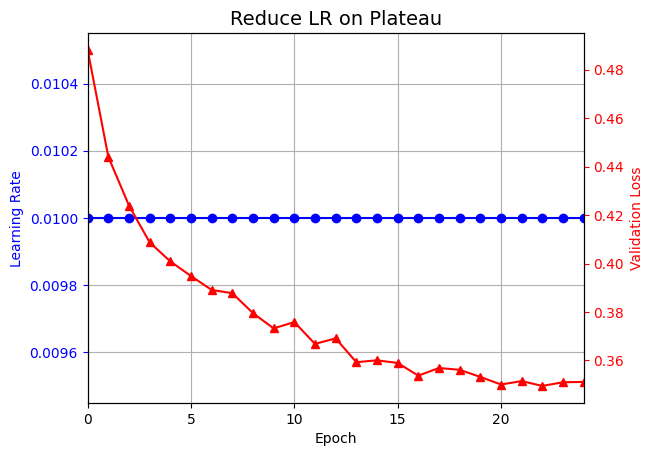

In [45]:
# Plot the performance scheduling. 

plt.plot(history.epoch, history.history["learning_rate"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

In [13]:
# We now implement 1Cycle Scheduling. 

K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]
        new_sum_of_epoch_losses = mean_epoch_loss * (batch+1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        lr = self.model.optimizer.learning_rate.numpy()
        self.rates.append(lr)
        self.losses.append(batch_loss)
        self.model.optimizer.learning_rate = lr * self.factor

In [14]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-04, max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1/iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    model.optimizer.learning_rate = min_rate
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs = epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    model.optimizer.learning_rate = init_lr
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

In [15]:
# Now we plot the learning rates. 

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.1972 - loss: 2.1119


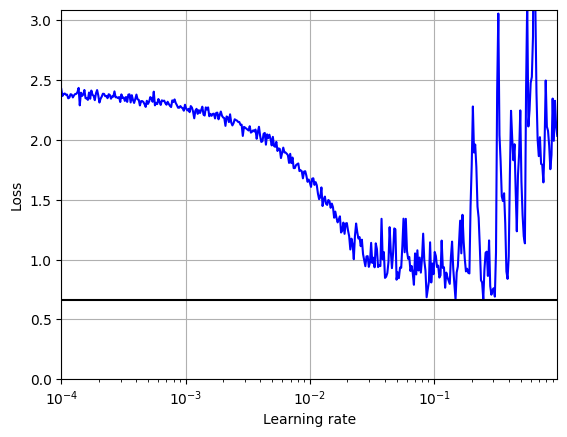

In [16]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy", optimizer = tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

batch_size = 128 
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [19]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations = None, last_lr = None):
        self.iterations = iterations 
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr/10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2-lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1
    
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr, self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration, self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations, self.start_lr, self.last_lr)
        
        self.iteration += 1
        self.model.optimizer.learning_rate = lr

In [20]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs,
                             max_lr=0.1)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle])

c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5446 - loss: 1.4051 - val_accuracy: 0.7928 - val_loss: 0.6063
Epoch 2/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7828 - loss: 0.6111 - val_accuracy: 0.8230 - val_loss: 0.5029
Epoch 3/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8159 - loss: 0.5218 - val_accuracy: 0.8304 - val_loss: 0.4708
Epoch 4/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8332 - loss: 0.4731 - val_accuracy: 0.8368 - val_loss: 0.4481
Epoch 5/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8454 - loss: 0.4376 - val_accuracy: 0.8358 - val_loss: 0.4401
Epoch 6/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8537 - loss: 0.4083 - val_accuracy: 0.8406 - val_loss: 0.4289
Epoch 7/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8604 - loss: 0.3860 - val_accuracy: 0.8504 - val_loss: 0.4127
Epoch 8/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8652 - loss: 0.3685 - val_accuracy: 0.

In [21]:
# We now avoid overfitting through regularization, specifically using L1 and L2. 

layer = tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal",
                              kernel_regularizer=tf.keras.regularizers.l2(0.01))

tf.random.set_seed(42)
from functools import partial

RegularizedDense = partial(tf.keras.layers.Dense,
                           activation="relu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0.01))

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2,
                    validation_data=(X_valid, y_valid))

c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7061 - loss: 4.1205 - val_accuracy: 0.8254 - val_loss: 1.8722
Epoch 2/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8132 - loss: 1.6335 - val_accuracy: 0.8248 - val_loss: 1.1229


In [22]:
# We now look into dropout. 

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6867 - loss: 0.8612 - val_accuracy: 0.8414 - val_loss: 0.4451
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8090 - loss: 0.5275 - val_accuracy: 0.8432 - val_loss: 0.4228
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8247 - loss: 0.4778 - val_accuracy: 0.8512 - val_loss: 0.4004
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8329 - loss: 0.4579 - val_accuracy: 0.8472 - val_loss: 0.3969
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8411 - loss: 0.4362 - val_accuracy: 0.8556 - val_loss: 0.3764
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8428 - loss: 0.4240 - val_accuracy: 0.8644 - val_loss: 0.3682
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8478 - loss: 0.4158 - val_accuracy: 0.8650 - val_loss: 0.3551
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8528 - loss: 0.4054 - 

In [23]:
print(model.evaluate(X_train, y_train))
print(model.evaluate(X_test, y_test))

# Note that if you build a self-normalizing NN with Selu, use Alphadropout.

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 866us/step - accuracy: 0.8854 - loss: 0.3082
[0.31029775738716125, 0.8848727345466614]
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.8644 - loss: 0.3675
[0.3713858723640442, 0.8614000082015991]


In [25]:
# We now look into Monte Carlo dropout. 

tf.random.set_seed(42)
y_probas = np.stack([model(X_test, training=True) for sample in range(100)])
y_proba = y_probas.mean(axis=0)
model.predict(X_test[:1]).round(3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.028, 0.   , 0.101, 0.   ,
        0.87 ]], dtype=float32)

In [26]:
y_proba[0].round(3)

array([0.   , 0.   , 0.   , 0.001, 0.   , 0.094, 0.   , 0.14 , 0.002,
       0.762], dtype=float32)

In [27]:
y_std = y_probas.std(axis=0)
y_std[0].round(3)

array([0.002, 0.001, 0.001, 0.003, 0.002, 0.146, 0.001, 0.139, 0.009,
       0.179], dtype=float32)

In [28]:
y_pred = y_proba.argmax(axis=1)
accuracy = (y_pred == y_test).sum() / len(y_test)
accuracy

0.8622

In [29]:
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

In [30]:
Dropout = tf.keras.layers.Dropout
mc_model = tf.keras.Sequential([
    MCDropout(layer.rate) if isinstance(layer, Dropout) else layer
    for layer in model.layers
])
mc_model.set_weights(model.get_weights())
mc_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mc_dropout (MCDropout)          │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mc_dropout_1 (MCDropout)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mc_dropout_2 (MCDropout)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,610 (350.04 KB)

 Trainable params: 89,610 (350.04 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
tf.random.set_seed(42)
np.mean([mc_model.predict(X_test[:1]) for sample in range(100)], axis=0).round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.17, 0.  , 0.73]],
      dtype=float32)

In [32]:
# We now look into Max norm regularization. 

dense = tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal",
                              kernel_constraint=tf.keras.constraints.max_norm(1.))

MaxNormDense = partial(tf.keras.layers.Dense,
                       activation="relu", kernel_initializer="he_normal",
                       kernel_constraint=tf.keras.constraints.max_norm(1.))
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(100),
    MaxNormDense(100),
    tf.keras.layers.Dense(10, activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10


c:\Users\coryg\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7392 - loss: 0.7403 - val_accuracy: 0.8330 - val_loss: 0.4322
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8458 - loss: 0.4230 - val_accuracy: 0.8446 - val_loss: 0.4055
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8594 - loss: 0.3840 - val_accuracy: 0.8386 - val_loss: 0.4084
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8670 - loss: 0.3618 - val_accuracy: 0.8524 - val_loss: 0.3917
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8703 - loss: 0.3480 - val_accuracy: 0.8482 - val_loss: 0.3971
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8727 - loss: 0.3408 - val_accuracy: 0.8474 - val_loss: 0.3933
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8757 - loss: 0.3329 - val_accuracy: 0.8516 - val_loss: 0.3887
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8780 - loss: 0.3270 - val_accur